In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import nsfg
import first
import thinkstats2
import thinkplot
import brfss
import hinc
import scipy.stats
import pandas as pd

ModuleNotFoundError: No module named 'nsfg'

**Exercise 2.4** 

Using the variable totalwgt_lb, investigate whether first babies are lighter or heavier than others. Compute Cohen’s d to quantify the difference between the groups. How does it compare to the difference in pregnancy length?

In [60]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups.
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

print("The average weight of first babies is {firsts} pounds. The average weight of babies born after the mother's first is {others} pounds".format(firsts = firsts.totalwgt_lb.mean(), others = others.totalwgt_lb.mean()))
print("The difference (Cohen's d between groups is {}.".format (CohenEffectSize(firsts.totalwgt_lb, others.totalwgt_lb)))

The average weight of first babies is 7.201094430437772 pounds. The average weight of babies born after the mother's first is 7.325855614973262 pounds
The difference (Cohen's d between groups is -0.088672927072602.


The average weight of a mother's first baby is lighter than their subsequent babies. On the other hand, the pregnancy lengths of a mother's first baby is generally longer than their subsequent babies.

**Exercise 3.1**: 

Something like the class size paradox appears if you survey children and ask how many children are in their family. Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

Use the NSFG respondent variable numkdhh to construct the actual distribution for the number of children under 18 in the respondents' households.

Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

In [ ]:
resp = nsfg.ReadFemResp()

In [ ]:
resp.numkdhh.value_counts().sort_index()
pmf = thinkstats2.Pmf(resp.numkdhh, label = 'numkdhh')

In [ ]:
def BiasPmf(pmf, label):
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    new_pmf.Normalize()
    return new_pmf

In [ ]:
biased_pmf = BiasPmf(pmf, label = 'biased')
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, biased_pmf])
thinkplot.Config(xlabel = 'number of children', ylabel = 'PMF')

In [ ]:
print('Actual mean', pmf.Mean())
print('Observed mean', biased_pmf.Mean())

**Exercise 4.2** 

The numbers generated by random.random are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability.
Generate 1000 numbers from random.random and plot their PMF and CDF. Is the distribution uniform?

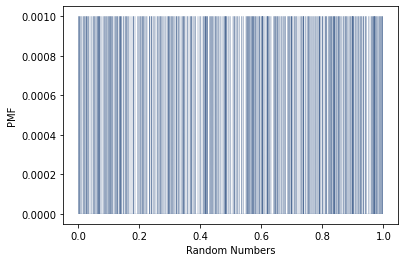

In [2]:
rand_int = np.random.random(1000)
width = 0.1
pmf = thinkstats2.Pmf(rand_int)
thinkplot.Pmf(pmf, linewidth = width)
thinkplot.Config(xlabel = 'Random Numbers', ylabel='PMF')


In [ ]:
cdf = thinkstats2.Cdf(rand_int)
thinkplot.Cdf(cdf, linewidth = 0.5)
thinkplot.Config(xlabel = 'Random Numbers', ylabel='CDF')


**Exercise 5.1** 

In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters μ = 178 cm and σ = 7.7 cm for men, and μ = 163 cm and σ = 7.3 cm for women.
In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use scipy.stats.norm.cdf.

In [ ]:
df = brfss.ReadBrfss()

mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
#Between 5'10" or 177.8 cm and 6'1" or 185.4 cm
low = dist.cdf(177.8)
high = dist.cdf(185.4)
print("There are {:.2f}% that are 177.8cm and {:.2f}% that are 185.4 cm. That means {:.2f}% of the population is in that range.".format(low * 100, high * 100, (high-low)*100))


**Exercise 6.1**

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households reports a taxable income below the mean? How do the results depend on the assumed upper bound?

In [ ]:
income_df = hinc.ReadData()

In [ ]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, row.freq)
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [ ]:
log_sample = InterpolateSample(income_df, log_upper = 6.0)


In [ ]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [ ]:
sample = np.power(10, log_sample)

In [ ]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

In [ ]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

In [ ]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

In [ ]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

In [ ]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [ ]:
mean = RawMoment(sample, 1)

In [ ]:
median = thinkstats2.Cdf(sample)

In [ ]:
skewness = StandardizedMoment(sample,3)

In [ ]:
pearson_skew = PearsonMedianSkewness(sample)

**Exercise 7.1** 

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [ ]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
live.head()

In [ ]:
thinkplot.Scatter(live.agepreg, live.totalwgt_lb, alpha = 0.1, s= 10)
thinkplot.Config(xlabel = "Mother's Age", ylabel = 'Weight of Baby')

In [ ]:
bins = np.arange(10, 46, 2)
indicies = np.digitize(live.agepreg, bins)
groups = live.groupby(indicies)

mean_age = [group.agepreg.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_age, weight_percentiles, label = label)
thinkplot.Config(xlabel = "Mother's Age", ylabel = 'Weight (lbs)')

In [ ]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

ages = live.agepreg
weights = live.totalwgt_lb
print('Corr', Corr(live.agepreg, live.totalwgt_lb))
print('SpearmanCorr', SpearmanCorr(live.agepreg, live.totalwgt_lb))

The scatter plot shows that there isn't a strong relationship between the variables. Pearson's correlation was around 0.07 while Spearman's was around 0.09, which shows a weak relationship. 


**Exercise 8.2**


Suppose you draw a sample with size n = 10 from an exponen- tial distribution with λ = 2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.
Repeat the experiment with a few different values of n and make a plot of standard error versus n.


In [27]:
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)
def SimulateSample(n=500, lam=2, iters=1000):
    estimates = []
    for j in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1/np.mean(xs)
        estimates.append(L)
    stderr = RMSE(estimates, lam)
    print('Standard error:', stderr)
    
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('Confidence interval:', ci)
    
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel = 'estimate', ylabel ='CDF', title = 'Exponential Distributions')
    return stderr

Standard error: 0.0864005079674776
Confidence interval: (1.8614649713609799, 2.1458690486897902)


0.0864005079674776

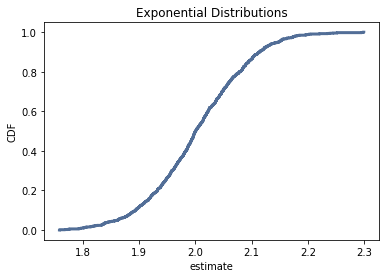

In [28]:
SimulateSample()

Simulte with a few different values of n:

    n= 10 
    standard error = 0.8258 confidence interval = 1.3113, 3.7054
    n = 100
    standard error = 0.2005 confidence interval = 1.7161, 2.3839
    n = 500
    standard error =  0.0864 Confidence interval = 1.8615, 2.1459
    n = 1000
    standard error = 0.06400 Confidence interval = 1.9004, 2.1083
As the number of samples increase, the standard error decreases, the range of the confidence interval is smaller.

**Exercise 8.3**

Write a function that takes a goal-scoring rate, lam, in goals per game, and simulates a game by generating the time between goals until the total time exceeds 1 game, then returns the number of goals scored.
Write another function that simulates many games, stores the estimates of lam, then computes their mean error and RMSE.
Is this way of making an estimate biased? Plot the sampling distribution of the estimates and the 90% confidence interval. What is the standard error? What happens to sampling error for increasing values of lam?

In [39]:
import random
def SimulateGame(lam):
    """Simulates a game and returns the estimated goal-scoring rate.

    lam: actual goal scoring rate in goals per game
    """
    goals = 0
    t = 0
    while True:
        time_between_goals = random.expovariate(lam)
        t += time_between_goals
        if t > 1:
            break
        goals += 1

    # estimated goal-scoring rate is the actual number of goals scored
    L = goals
    return L

In [53]:
def MeanError(estimates, actual):
    errors = [estimate - actual for estimate in estimates]
    return np.mean(errors)
def Estimate(lam = 10, n=100000):
    estimates = []
    for i in range(n):
        L=SimulateGame(lam)
        estimates.append(L)
    print('RMSE L', RMSE(estimates, lam))
    print('Mean Error L', MeanError(estimates, lam))
    
    pmf = thinkstats2.Pmf(estimates)
    thinkplot.Hist(pmf)
    thinkplot.Config(xlabel = 'Goals scored', ylabel = 'PMF')

RMSE L 3.1644383387893655
Mean Error L -0.01275


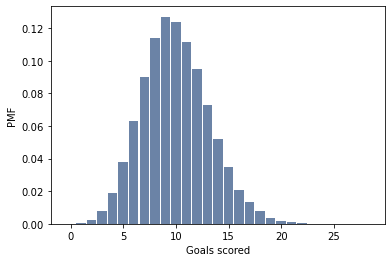

In [54]:
Estimate()

The standard error is 0.00282 and the root mean squared error is 1.4. Increasing n will decrease the error. 
Increasing lam will increase both RMSE and mean error.

**Exercise 9.2**

In Section 9.3, we simulated the null hypothesis by permuta- tion; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named DiffMeansResample that inherits from DiffMeansPermute and overrides RunModel to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [61]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
class DiffMeansResample(DiffMeansPermute):
    def RunModel(self):
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2
    
    
def RunResampleTest(first,others):
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters = 10000)
    print('\ndiff means resample preglength')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample birthweight')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

In [62]:
RunResampleTest(firsts,others)


diff means resample preglength
p-value = 0.1693
actual = 0.07803726677754952
ts max = 0.21475581768467578

diff means resample birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.10961257217657927


The two modles are only slightly different. Using resampling or permutation give similar results so there is no reason to choose one or the other.